In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

# check if model exists
from pathlib import Path
CWD = Path.cwd()
models_dir = CWD / "models"

In [2]:
if False:
    # Define the root directory where the dataset will be stored
    root_dir = "./data"

    # Download the CelebA dataset (including annotations)
    celeba_dataset = datasets.CelebA(root=root_dir, split="all", download=True)

    print("CelebA dataset downloaded successfully!")
    import os

    data_path = "./data/celeba"
    print("Dataset files:", os.listdir(data_path))

    import torchvision.datasets as datasets
    import torchvision.transforms as transforms
    from torch.utils.data import DataLoader

    # Define transformations: Convert images to tensors
    transform = transforms.Compose([
        transforms.ToTensor()  # Converts PIL Image to PyTorch Tensor
    ])

    # Load CelebA dataset with transforms

    # Create a DataLoader
    celeba_loader = DataLoader(celeba_dataset, batch_size=32, shuffle=True)

    if False:
        # Get a batch of images and labels
        images, labels = next(iter(celeba_loader))

        # Print batch shape
        print("Batch shape:", images.shape)  # Should be (32, 3, 218, 178)
    celeba_dataset = datasets.CelebA(root=DATA_DIR, split="all", download=True, transform=transform)


In [3]:
from torch.utils.data import DataLoader, Subset

BATCH_SIZE = 64  # Increase batch size for better training
NUM_WORKERS = 4
DATA_DIR = "data"



# ========================
# 2. DATA LOADING (WITH STRONG AUGMENTATION)
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")

train_labels = train_dataset.attr
val_labels = val_dataset.attr

if True: # only for debugging - train on 30% of the training set
    TRAIN_SPLIT =VAL_SPLIT = 0.25
    # Get 30% indices
    train_size = int(TRAIN_SPLIT * len(train_dataset))
    val_size = int(VAL_SPLIT * len(val_dataset))
    import numpy as np

    # Randomly sample 30% of the indices
    train_indices = np.random.choice(len(train_dataset), train_size, replace=False)
    val_indices = np.random.choice(len(val_dataset), val_size, replace=False)

    # Create subset datasets
    train_dataset = Subset(train_dataset, train_indices)
    val_dataset = Subset(val_dataset, val_indices)
    subset_targets_train = train_labels[train_indices]
    subset_targets_val = val_labels[val_indices]

    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Files already downloaded and verified
Files already downloaded and verified


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)

Using device: cuda


In [5]:


# ========================
# 5. TRAINING FUNCTION
# ========================
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, SAVE_MODEL_PATH= None):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")
        # Validation
        validate(model, val_loader, criterion)
        evaluate(model, val_loader)
        scheduler.step()  # Update learning rate

        if SAVE_MODEL_PATH is not None:
            print(f"Saving model to {SAVE_MODEL_PATH}")
            # Save model checkpoint
            torch.save(model.state_dict(), SAVE_MODEL_PATH)

# ========================
# 6. VALIDATION FUNCTION
# ========================
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")

# ========================
# 7. EVALUATION FUNCTION
# ========================
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            logits = model(images)
            probs = torch.sigmoid(logits)  # Convert logits to probabilities
            preds = (probs > 0.5).int()  # Threshold at 0.5 to get binary predictions

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all predictions and labels
    preds = torch.cat(all_preds)
    true_labels = torch.cat(all_labels)

    # Compute per-class accuracy
    per_class_accuracy = (preds == true_labels).float().mean(dim=0)

    # Compute overall accuracy (average across all attributes)
    overall_accuracy = per_class_accuracy.mean().item()

    # Print results
    print(f"Overall accuracy: {overall_accuracy:.4f}")
    print(f"Per-attribute accuracy:\n{per_class_accuracy}")

    return per_class_accuracy, overall_accuracy

In [20]:

ignore_base_model = True

base_model_path = models_dir/  "resnet50_scratch_celeba.pth"



# ========================
# 1. CONFIGURATION
# ========================
#IMAGE_SIZE = 224
NUM_EPOCHS = 20  # More epochs needed
LEARNING_RATE = 0.01  # Higher initial LR when training from scratch


# ========================
# 3. MODEL DEFINITION (TRAINING FROM SCRATCH)
# ========================
model = models.resnet50(pretrained=False)  # Train from scratch
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 40)  # Modify final layer for 40 attributes
model = model.to(DEVICE)

if not base_model_path.exists():
    # ========================
    # 4. LOSS & OPTIMIZER
    # ========================
    print(f"training from scratch")
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)  # SGD with momentum

    # Learning rate scheduler (reduce LR after plateaus)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)  # Reduce LR every 15 epochs
    # ========================
    # 8. TRAIN & EVALUATE MODEL
    # ========================
    train(model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, SAVE_MODEL_PATH=base_model_path)
else:
    print(f"loading from memory")
    model.load_state_dict(torch.load(base_model_path))
    model.eval()

evaluate(model, val_loader)


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader ru

Overall accuracy: 0.8135
Per-attribute accuracy:
tensor([0.8846, 0.7475, 0.5695, 0.7910, 0.9785, 0.8538, 0.8504, 0.7443, 0.7918,
        0.8498, 0.9541, 0.7531, 0.8602, 0.9364, 0.9484, 0.9293, 0.9265, 0.9468,
        0.6492, 0.5493, 0.6236, 0.5230, 0.9499, 0.9219, 0.8256, 0.7271, 0.9559,
        0.7165, 0.9289, 0.9307, 0.9305, 0.5252, 0.7865, 0.7308, 0.8045, 0.9474,
        0.6532, 0.8802, 0.9257, 0.7380])


(tensor([0.8846, 0.7475, 0.5695, 0.7910, 0.9785, 0.8538, 0.8504, 0.7443, 0.7918,
         0.8498, 0.9541, 0.7531, 0.8602, 0.9364, 0.9484, 0.9293, 0.9265, 0.9468,
         0.6492, 0.5493, 0.6236, 0.5230, 0.9499, 0.9219, 0.8256, 0.7271, 0.9559,
         0.7165, 0.9289, 0.9307, 0.9305, 0.5252, 0.7865, 0.7308, 0.8045, 0.9474,
         0.6532, 0.8802, 0.9257, 0.7380]),
 0.8134918212890625)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']


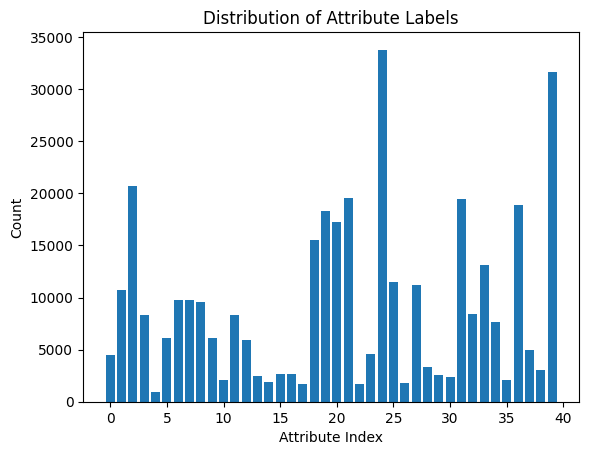

In [7]:
# 1 identify labels of attributes
#attribute_labels = 
print(train_dataset.dataset.attr_names)
# print histogram of labels
import matplotlib.pyplot as plt

import numpy as np
subset_targets = subset_targets_train
counts = np.sum(subset_targets.numpy(), axis=0)
counts
# plot bar chart of counts
plt.bar(range(len(counts)), counts)
plt.xlabel("Attribute Index")
plt.ylabel("Count")
plt.title("Distribution of Attribute Labels")
plt.show()

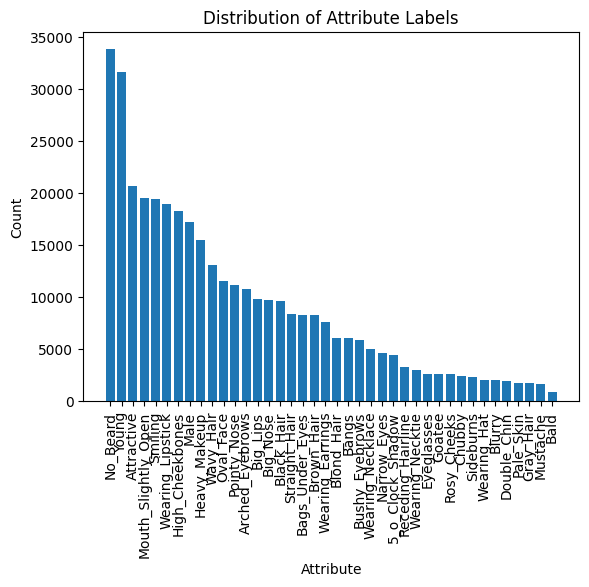

In [8]:
attribute_to_count = {train_dataset.dataset.attr_names[i] : counts[i] for i in range(len(counts))}
# Sort attributes by count
sorted_attributes = sorted(attribute_to_count.items(), key=lambda x: x[1], reverse=True)
# Print sorted attributes
#for attr, count in sorted_attributes:
#    print(f"{attr}: \t\t {count}")
# plot sorted attributes with counts, with text annotainos
x_axis = [attr for attr, count in sorted_attributes]
y_axis = [count for attr, count in sorted_attributes]
plt.bar(x_axis, y_axis)
plt.xlabel("Attribute")
plt.ylabel("Count")
plt.title("Distribution of Attribute Labels")
plt.xticks(rotation=90)
plt.show()

In [9]:
subset_targets_np = subset_targets.numpy()

correlation_matrix = np.corrcoef(subset_targets_np, rowvar=False)
correlation_matrix.shape

(40, 40)

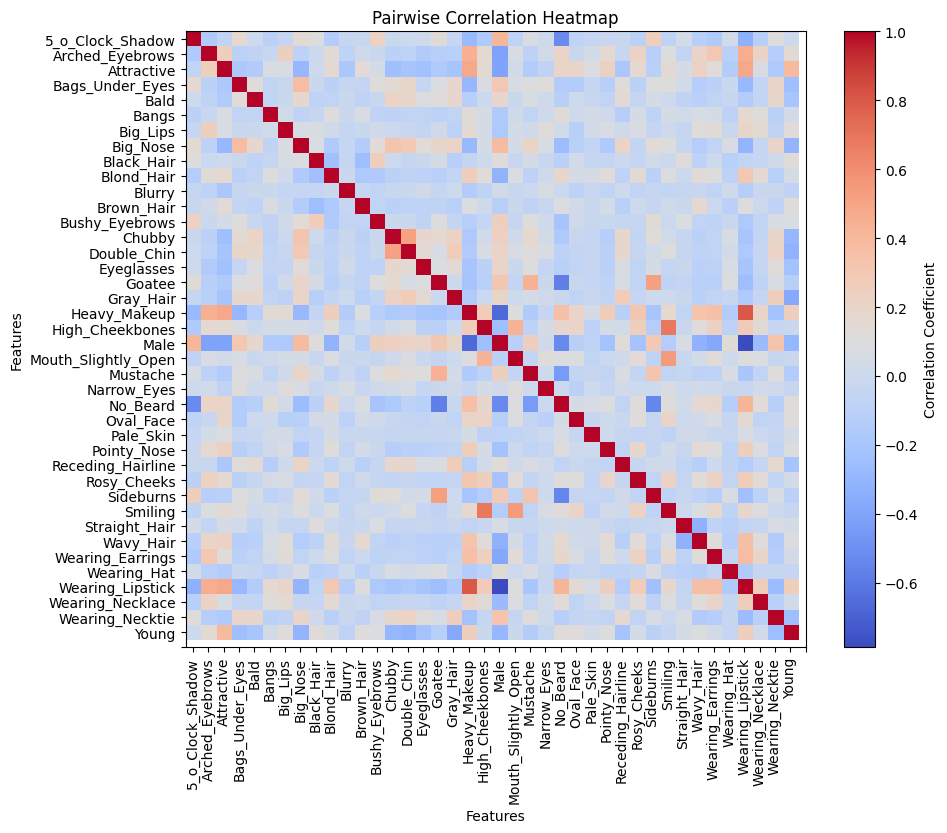

In [10]:
import matplotlib.pyplot as plt
attr_names = train_dataset.dataset.attr_names

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Correlation Coefficient")

# Set x and y ticks
plt.xticks(ticks=range(len(attr_names)), labels=attr_names, rotation=90)
plt.yticks(ticks=range(len(attr_names)), labels=attr_names)

plt.title("Pairwise Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()


In [11]:
average_correlation = np.mean(correlation_matrix, axis=1)
attribute_to_correlation = {train_dataset.dataset.attr_names[i] : correlation_matrix[i] for i in range(len(correlation_matrix))}
# Sort attributes by average correlation
sorted_attributes = sorted(attribute_to_correlation.items(), key=lambda x: np.mean(x[1]), reverse=True)
# Print sorted attributes
for attr, correlation in sorted_attributes:
    print(f"{attr}: \t\t {np.mean(correlation):.4f}")

Smiling: 		 0.0920
High_Cheekbones: 		 0.0878
Mouth_Slightly_Open: 		 0.0697
Rosy_Cheeks: 		 0.0651
Heavy_Makeup: 		 0.0615
Arched_Eyebrows: 		 0.0607
Wearing_Lipstick: 		 0.0558
Wearing_Earrings: 		 0.0554
Big_Lips: 		 0.0532
Double_Chin: 		 0.0515
Big_Nose: 		 0.0513
Wearing_Necklace: 		 0.0481
Chubby: 		 0.0478
Attractive: 		 0.0418
Narrow_Eyes: 		 0.0378
Pointy_Nose: 		 0.0359
Bags_Under_Eyes: 		 0.0352
Oval_Face: 		 0.0345
Wavy_Hair: 		 0.0341
Mustache: 		 0.0323
Receding_Hairline: 		 0.0322
Bald: 		 0.0303
Bushy_Eyebrows: 		 0.0299
Wearing_Necktie: 		 0.0297
Blond_Hair: 		 0.0267
Gray_Hair: 		 0.0264
Goatee: 		 0.0257
Sideburns: 		 0.0215
Bangs: 		 0.0214
Black_Hair: 		 0.0159
Pale_Skin: 		 0.0145
Straight_Hair: 		 0.0087
Eyeglasses: 		 0.0069
Brown_Hair: 		 0.0029
5_o_Clock_Shadow: 		 0.0020
Young: 		 0.0001
No_Beard: 		 -0.0030
Wearing_Hat: 		 -0.0079
Blurry: 		 -0.0101
Male: 		 -0.0230


In [12]:
attribute_ = "Bags_Under_Eyes"
attr_index = train_dataset.dataset.attr_names.index(attribute_)
attr_index

indices_without_attr = np.where(subset_targets_np[:, attr_index] == 0)[0]
print("Number of samples without attribute:", len(indices_without_attr))

dataset_without_attribute = Subset(train_dataset, indices_without_attr)
len(dataset_without_attribute)
# train on dataset without attribute

train_loader_without_attr = DataLoader(dataset_without_attribute, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)



Number of samples without attribute: 32377


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:

SAVE_MODEL_PATH = f"resnet50_celeba__remove_{attr_index}.pth"


model_path = models_dir / SAVE_MODEL_PATH
model_path.exists()

True

In [17]:
#


# ========================
# 1. CONFIGURATION
# ========================
#IMAGE_SIZE = 224
NUM_EPOCHS = 20  # More epochs needed
LEARNING_RATE = 0.01  # Higher initial LR when training from scratch

# ========================
# 3. MODEL DEFINITION
# ========================

model_without_attr = models.resnet50(pretrained=False)  # Train from scratch
num_ftrs = model_without_attr.fc.in_features
model_without_attr.fc = nn.Linear(num_ftrs, 40)  # Modify final layer for 40 attributes
model_without_attr = model_without_attr.to(DEVICE)

if model_path.exists():
    # load model 
    print(f"loading model from {model_path}")
    model_without_attr.load_state_dict(torch.load(model_path))
else:
    print(f"model not found at {model_path}; training model from scratch")
    # ========================
    # 4. LOSS & OPTIMIZER
    # ========================
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model_without_attr.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)  # SGD with momentum

    # Learning rate scheduler (reduce LR after plateaus)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)  # Reduce LR every 15 epochs
    # ========================
    # 8. TRAIN & EVALUATE MODEL
    # ========================
    train(model_without_attr, train_loader_without_attr, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, SAVE_MODEL_PATH=SAVE_MODEL_PATH)
evaluate(model_without_attr, val_loader)

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


loading model from /n/home04/rrinberg/code/data_to_concept_unlearning/notebooks/models/resnet50_celeba__remove_3.pth


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Overall accuracy: 0.9103
Per-attribute accuracy:
tensor([0.9331, 0.8407, 0.8081, 0.7910, 0.9873, 0.9563, 0.8409, 0.8159, 0.9072,
        0.9517, 0.9629, 0.8558, 0.9285, 0.9466, 0.9553, 0.9946, 0.9648, 0.9746,
        0.9090, 0.8826, 0.9843, 0.9430, 0.9589, 0.9295, 0.9503, 0.7523, 0.9631,
        0.7630, 0.9472, 0.9491, 0.9631, 0.9283, 0.8276, 0.8347, 0.8947, 0.9863,
        0.9195, 0.8840, 0.9571, 0.8703])


(tensor([0.9331, 0.8407, 0.8081, 0.7910, 0.9873, 0.9563, 0.8409, 0.8159, 0.9072,
         0.9517, 0.9629, 0.8558, 0.9285, 0.9466, 0.9553, 0.9946, 0.9648, 0.9746,
         0.9090, 0.8826, 0.9843, 0.9430, 0.9589, 0.9295, 0.9503, 0.7523, 0.9631,
         0.7630, 0.9472, 0.9491, 0.9631, 0.9283, 0.8276, 0.8347, 0.8947, 0.9863,
         0.9195, 0.8840, 0.9571, 0.8703]),
 0.91033536195755)

In [23]:
num_ftrs

2048

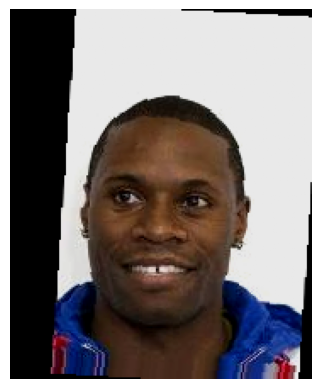

In [18]:


# Example usage

import torch
import torch.nn as nn

def get_nth_to_last_embedding(model, x, n=1):
    """
    Extract embedding from the n-th to last layer of ResNet.
    Args:
        model: ResNet model (e.g., ResNet50)
        x: Input image tensor (batch_size, 3, H, W)
        n: Number of layers to remove from the end (default: 2 for second-to-last layer)
    Returns:
        features: Extracted feature tensor
    """
    # Get model layers except last n layers
    truncated_model = nn.Sequential(*list(model.children())[:-n])
    
    with torch.no_grad():
        features = truncated_model(x)  # Pass input through the truncated model
        features = features.squeeze(-1).squeeze(-1)  # Remove unnecessary dimensions

    return features

# Example usage:
# x = torch.randn(1, 3, 224, 224).to(device)  # Example input
# embedding = get_nth_to_last_embedding(model, x, n=2)  # Extract second-to-last layer
# print(embedding.shape)

def get_embedding(model, x):
    return get_nth_to_last_embedding(model, x, n=1)


import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

def show_image(tensor_img):
    """
    Displays an image from a tensor.
    """
    if isinstance(tensor_img, torch.Tensor):
        tensor_img = tensor_img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Normalize range from [-1, 1] to [0, 1] if needed
    tensor_img = (tensor_img * 0.5) + 0.5  # Assuming CelebA normalization [-1,1] -> [0,1]
    tensor_img = tensor_img.clip(0, 1)

    plt.imshow(tensor_img)
    plt.axis("off")
    plt.show()

# Example usage
index = 12  # Change index as needed
img_tensor = train_dataset[index][0]  # Get image tensor
show_image(img_tensor)


In [27]:
attr_index

3

Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
-----2-----
Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
Accuracy of logistic regression on embeddings for without_attr: 0.7300
embedding shape (2000, 2048)
n 1000


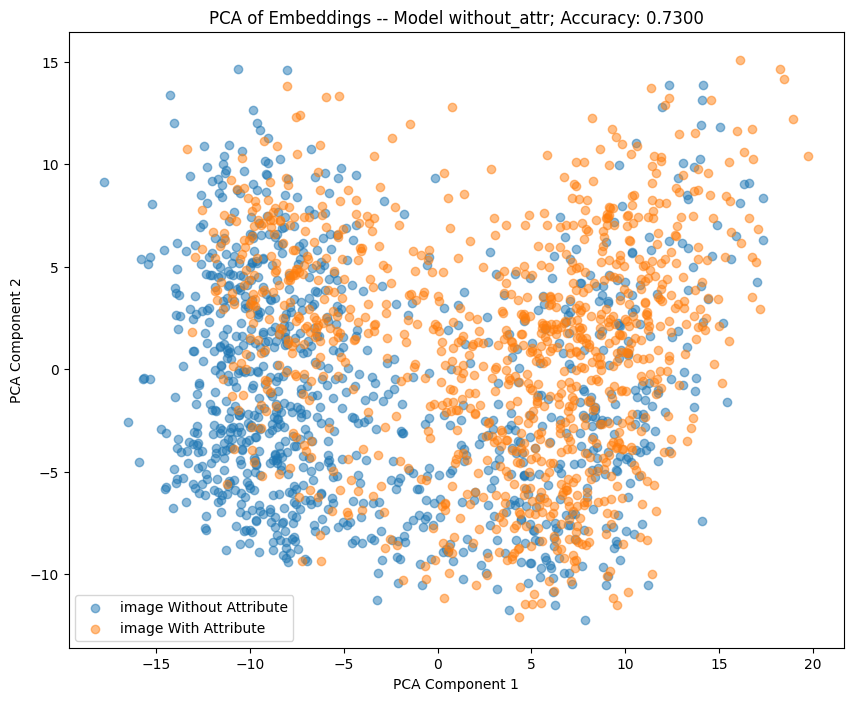

In [26]:
model_ = model 
model_ = model_without_attr
cpu_device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


models = [("with_attr", model), ("without_attr", model_without_attr)]
models = [("without_attr", model_without_attr)]
for name, model_ in models:
    indices_without_attr = np.where(subset_targets_np[:, attr_index] == 0)[0]
    indices_with_attr = np.where(subset_targets_np[:, attr_index] == 1)[0]

    num_images = 1000
    # Get embeddings for images without attribute
    embeddings_without_attr = []
    for ii, idx in enumerate(indices_without_attr[:num_images]):
        if ii % 50 == 0:
            print("Processing sample", ii)
        img_tensor = train_dataset[idx][0].unsqueeze(0).to(device)  # Add batch dimension
        embedding = get_embedding(model_.to(device), img_tensor)
        embeddings_without_attr.append(embedding.cpu().numpy())
    print("-----2-----")
    # Get embeddings for images with attribute
    embeddings_with_attr = []
    for ii, idx in enumerate(indices_with_attr[:num_images]):
        if ii % 50 == 0:
            print("Processing sample", ii)
        img_tensor = train_dataset[idx][0].unsqueeze(0).to(device)  # Add batch dimension
        embedding = get_embedding(model_.to(device), img_tensor)
        embeddings_with_attr.append(embedding.cpu().numpy())
    all_embeddings = embeddings_without_attr + embeddings_with_attr
    # stack
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    labels_ = np.concatenate([np.zeros(len(embeddings_without_attr)), np.ones(len(embeddings_with_attr))])


    # train logistic regression on embeddings and labels
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import train_test_split
    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(all_embeddings, labels_, test_size=0.2, random_state=42)
    # train logistic regression
    logreg = LogisticRegression(max_iter=1000, solver="liblinear")
    logreg.fit(X_train, y_train)
    preds = logreg.predict(X_test)
    acc = accuracy_score(y_test, preds)

    #acc = accuracy_score(labels_, preds)
    print(f"Accuracy of logistic regression on embeddings for {name}: {acc:.4f}")
    print(f"embedding shape {all_embeddings.shape}")
    n = len(embeddings_with_attr)
    print(f"n {n}")
    # run PCA on embeddings
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import numpy as np
    #embeddings_without_attr_np = np.concatenate(embeddings_without_attr, axis=0)
    #embeddings_with_attr_np = np.concatenate(embeddings_with_attr, axis=0)
    #embeddings_with_attr_np.shape
    # plot embeddings with PCA
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(all_embeddings)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_embeddings[:n, 0], pca_embeddings[:n, 1], label="image Without Attribute", alpha=0.5)
    plt.scatter(pca_embeddings[n:, 0], pca_embeddings[n:, 1], label="image With Attribute", alpha=0.5)
    plt.title(f"PCA of Embeddings -- Model {name}; Accuracy: {acc:.4f}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()


In [22]:
embedding.shape

torch.Size([1, 2048])